In [159]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from train_utils import *
from input_prep import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Seq from real

In [160]:
sorted(glob.glob("/media/beans/ssd/bespoke_logging/*"))
#sorted(glob.glob("/home/beans/bespoke_logging/*"))

['/media/beans/ssd/bespoke_logging/run_351',
 '/media/beans/ssd/bespoke_logging/run_352',
 '/media/beans/ssd/bespoke_logging/run_353',
 '/media/beans/ssd/bespoke_logging/run_354',
 '/media/beans/ssd/bespoke_logging/run_355',
 '/media/beans/ssd/bespoke_logging/run_356',
 '/media/beans/ssd/bespoke_logging/run_357',
 '/media/beans/ssd/bespoke_logging/run_358',
 '/media/beans/ssd/bespoke_logging/run_359',
 '/media/beans/ssd/bespoke_logging/run_359a',
 '/media/beans/ssd/bespoke_logging/run_359b',
 '/media/beans/ssd/bespoke_logging/run_360',
 '/media/beans/ssd/bespoke_logging/run_361',
 '/media/beans/ssd/bespoke_logging/run_362',
 '/media/beans/ssd/bespoke_logging/run_363',
 '/media/beans/ssd/bespoke_logging/run_364',
 '/media/beans/ssd/bespoke_logging/run_365',
 '/media/beans/ssd/bespoke_logging/run_366',
 '/media/beans/ssd/bespoke_logging/run_367',
 '/media/beans/ssd/bespoke_logging/run_368',
 '/media/beans/ssd/bespoke_logging/run_369',
 '/media/beans/ssd/bespoke_logging/run_370',
 '/media

In [161]:
#run_id = "run_382" # out sabq to pow to grade
#run_id = "run_383" # back from grade, 214, madrona, sunny
#run_id = "run_392" # back from nabq, creeper on ev, sunny
#run_id = "run_396" # back from nabq, on 213, cloudy
#run_id = "run_402" # back from nabq, on 213, sunny
#run_id = "run_404" # # out to end sabq
#run_id = "run_412" # back from end nabq, sunny

run_id = "run_492" # to mid nabq and back, sunny, a few map blips at due south
#run_id = "run_492a" # out ev
#run_id = "run_492d" # out sabq




run_path = f"/media/beans/ssd/bespoke_logging/{run_id}"
#run_path = f"/home/beans/bespoke_logging/{run_id}"

model_stem = "8.18_e63" #"8.18_e34"

In [162]:
aux_paths = sorted(glob.glob(f"{run_path}/aux/*"))
img_paths = sorted(glob.glob(f"{run_path}/img/*"))
car_state_paths = sorted(glob.glob(f"{run_path}/car_state/*"))
m = min([len(aux_paths), len(img_paths), len(car_state_paths)])
len(aux_paths), len(img_paths), len(car_state_paths), m

(41208, 41208, 41208, 41208)

In [163]:
s, e = 0, -100 #-100 #9400, 11_400 #4000
#e = m

aux = np.stack([np.load(f) for f in aux_paths[s:e]]).astype(np.float16)
img = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/img/*"))[s:e]]).astype(np.uint8)
car_state = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/car_state/*"))[s:e]])#.astype(np.float16)

steer_angle = np.radians(car_state[:,0] / (STEER_RATIO)) #*-1  
tire_angle_rad = steer_angle *-1
img.shape, aux.shape, car_state.shape

((41108, 100, 640, 3), (41108, 5), (41108, 14))

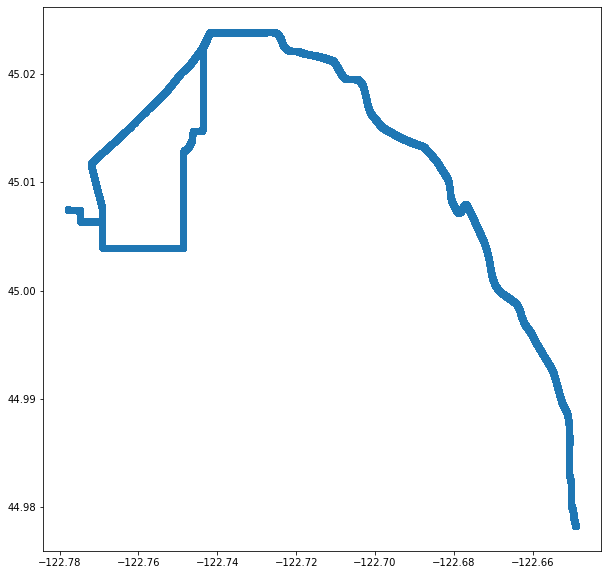

In [164]:
plt.figure(figsize=(10,10))

lats, lons = car_state[:,-2], car_state[:,-1]

plt.scatter(lons, lats)

In [165]:
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

In [166]:
headings = []
for i in range(10, len(lats), 5):
    prev_lat, prev_lon = lats[i-10], lons[i-10]
    fwd_azimuth, back_azimuth, distance = geodesic.inv(prev_lon, prev_lat, lons[i], lats[i]) 
    headings.append(fwd_azimuth)

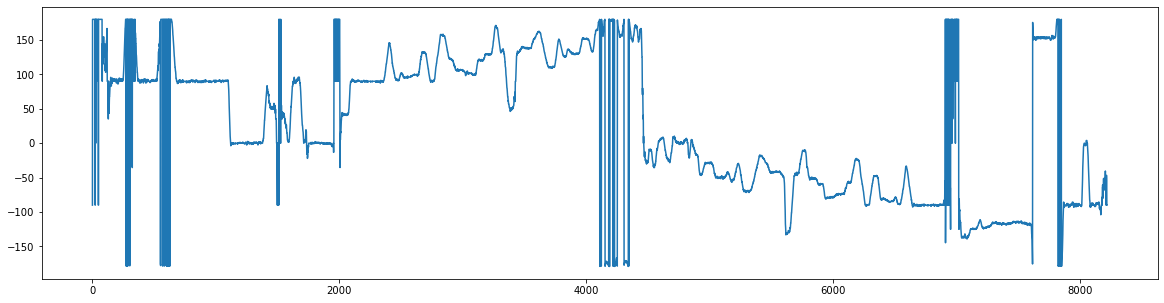

In [167]:
plt.figure(figsize=(20,5))
plt.plot(headings)

In [168]:
from map_utils import *
from big_map_utils import *

In [169]:
big_lats, big_lons, way_ids = get_big_map()

In [262]:
vehicle_heading = np.radians(240) # fake number
LON_MULT = get_lon_mult(big_lats.mean())
ix = 37_000
small_map = get_map(big_lats, big_lons*LON_MULT, way_ids, lats[ix], lons[ix]*LON_MULT, vehicle_heading+np.pi/2, CLOSE_BUFFER)

In [263]:
big_lats.mean()

44.99004223687407

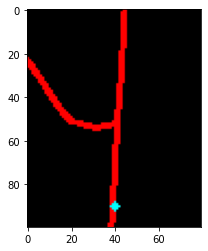

In [264]:
plt.imshow(small_map)

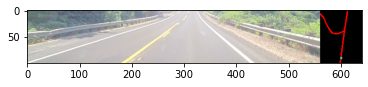

In [265]:
plt.imshow(img[ix])

In [173]:
commanded_torque = car_state[:, 7]

array([2.9000e+01, 3.0000e+01, 7.1000e+01, 3.8000e+02, 5.8880e+03,
       3.2639e+04, 2.0130e+03, 3.2000e+01, 1.8000e+01, 8.0000e+00])

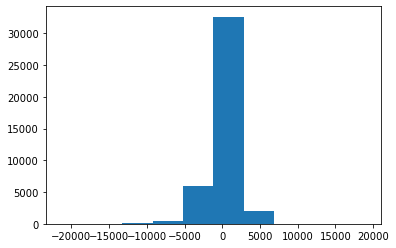

In [174]:
plt.hist(commanded_torque)[0]

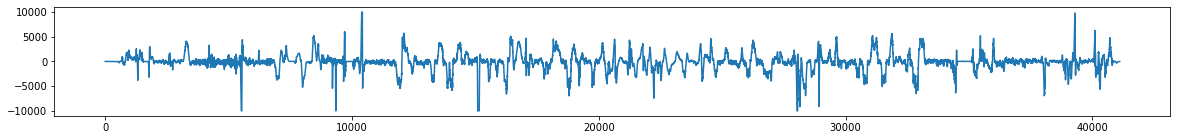

In [175]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_torque, -10_000, 10_000))

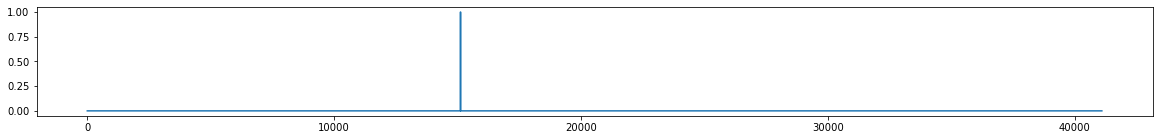

In [176]:
# abs torque limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 9])

array([ 1136.,   223.,   410.,  1541., 18037., 16533.,  1635.,   626.,
         337.,   630.])

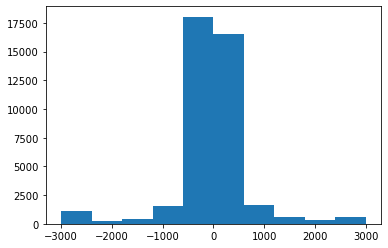

In [177]:
commanded_td = car_state[:, 8]
plt.hist(np.clip(commanded_td, -3000, 3000))[0]

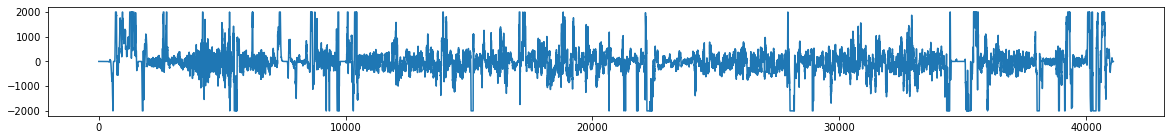

In [178]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_td, -2000, 2000))

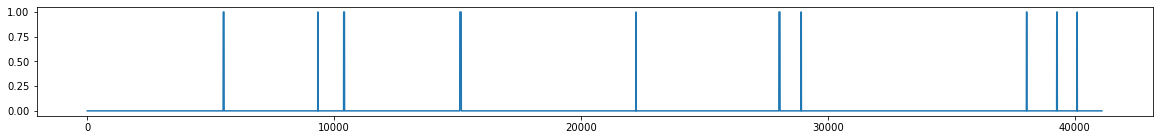

In [179]:
# Td limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 10])

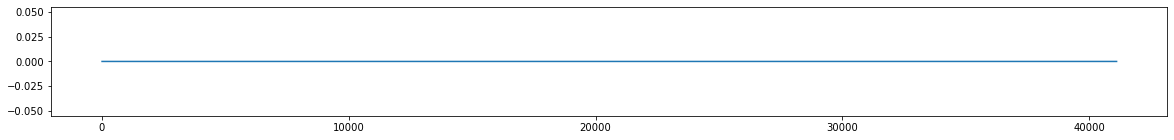

In [180]:
# interesting note
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 11])

In [181]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(car_state[:, 10], width=900, height=400)
fig.show()

In [182]:
#plt.imshow(img[15_750])

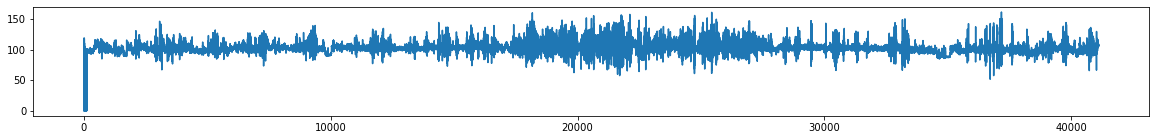

In [183]:
# seeing if cam is too slow, ie if we ever have repeated imgs

diffs = []
for i in range(len(img)-1):
    diff = (img[i] - img[i+1]).mean()
    diffs.append(diff)
    
# whether or not image is same as prev img, ie cam is slow. We just don't want to see zeros
plt.figure(figsize=(20,2))
plt.plot(diffs)

(array([4.3000e+01, 2.3700e+04, 1.1978e+04, 3.7150e+03, 1.2130e+03,
        2.9000e+02, 7.5000e+01, 2.6000e+01, 1.9000e+01, 1.3000e+01,
        1.0000e+01, 8.0000e+00, 3.0000e+00, 5.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([15.  , 16.05, 17.1 , 18.15, 19.2 , 20.25, 21.3 , 22.35, 23.4 ,
        24.45, 25.5 , 26.55, 27.6 , 28.65, 29.7 , 30.75, 31.8 , 32.85,
        33.9 , 34.95, 36.  ]),
 <BarContainer object of 20 artists>)

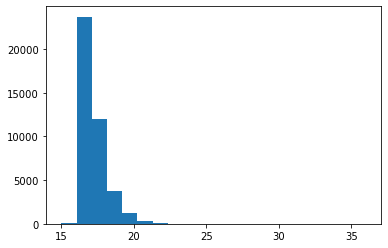

In [184]:
# timespan btwn start to get img, and publish plan, ie the timespan WE have control over
# img staleness
plt.hist(car_state[:,2], bins=20)

In [185]:
b,e = 0, -1
img = img[b:e]
aux = aux[b:e]
car_state = car_state[b:e]
steer_angle = steer_angle[b:e]
img.shape, aux.shape, car_state.shape, steer_angle.shape, #pred.shape

((41107, 100, 640, 3), (41107, 5), (41107, 14), (41107,))

(array([  149.,  1150.,  2085.,  3316., 27412.,  3385.,  2241.,  1189.,
          151.,    29.]),
 array([-6987.60012341, -5453.77514324, -3919.95016308, -2386.12518291,
         -852.30020275,   681.52477741,  2215.34975758,  3749.17473774,
         5282.9997179 ,  6816.82469807,  8350.64967823]),
 <BarContainer object of 10 artists>)

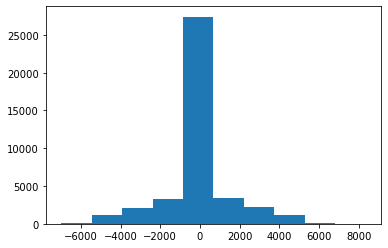

In [186]:
torque = np.degrees(steer_angle) * (aux[:,2]**2)
plt.hist(torque)

(array([3.0000e+00, 7.0000e+00, 1.4000e+01, 7.5000e+01, 1.8070e+03,
        3.7862e+04, 1.2430e+03, 7.3000e+01, 1.7000e+01, 5.0000e+00]),
 array([-1053.38127184,  -859.64815059,  -665.91502935,  -472.1819081 ,
         -278.44878685,   -84.71566561,   109.01745564,   302.75057688,
          496.48369813,   690.21681938,   883.94994062]),
 <BarContainer object of 10 artists>)

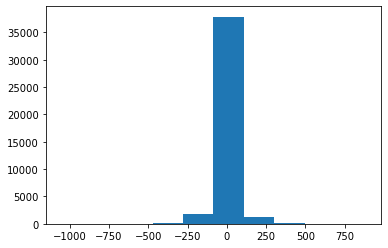

In [187]:
plt.hist(torque[1:]-torque[:-1])

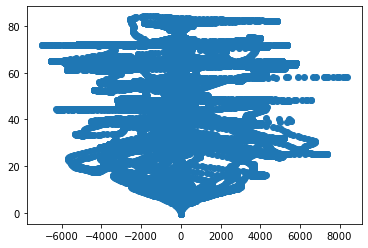

In [188]:
plt.scatter(torque, aux[:,2])

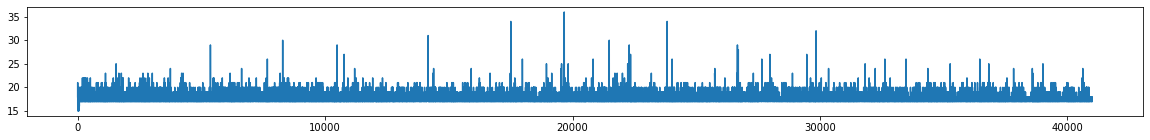

In [189]:
# img staleness
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,2])

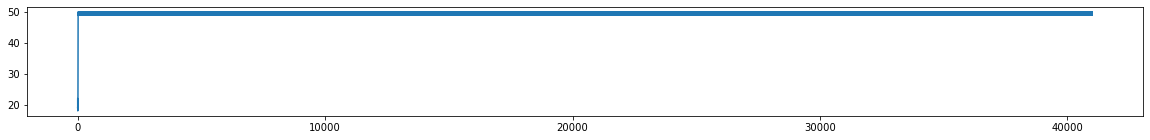

In [190]:
# loop duration
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,3])

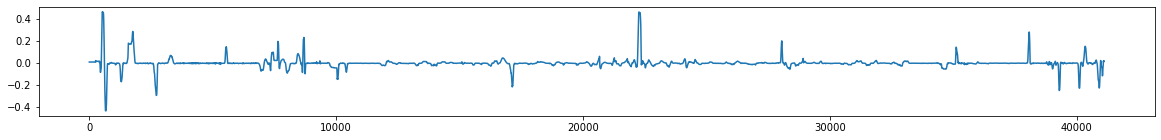

In [191]:
# steer angle
plt.figure(figsize=(20,2))
plt.plot(steer_angle)

In [192]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=range(len(steer_angle)), y=steer_angle, width=900, height=400)
fig.show()

(array([   57.,    62.,   258.,   490., 36479.,  2913.,   455.,   184.,
           47.,   162.]),
 array([-0.43458698, -0.34442981, -0.25427265, -0.16411548, -0.07395832,
         0.01619884,  0.10635601,  0.19651317,  0.28667034,  0.3768275 ,
         0.46698466]),
 <BarContainer object of 10 artists>)

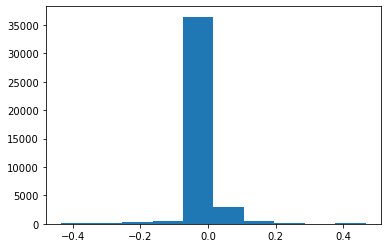

In [193]:
plt.hist(steer_angle)

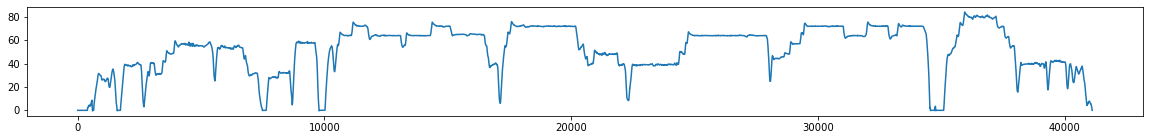

In [194]:
# speed
plt.figure(figsize=(20,2))
plt.plot(aux[:,2])

(array([2369.,  637.,  914., 3027., 6163., 3474., 5332., 9551., 8275.,
        1365.]),
 array([-0.4473,  8.016 , 16.48  , 24.94  , 33.4   , 41.88  , 50.34  ,
        58.8   , 67.25  , 75.75  , 84.2   ], dtype=float16),
 <BarContainer object of 10 artists>)

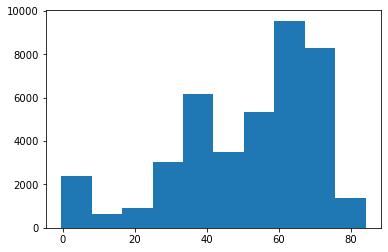

In [195]:
# speed
plt.hist(aux[:,2])

In [196]:
"""import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)
#fig.update_xaxes(range=[0, 50])
fig.update_yaxes(range=[0, 12])
fig.show()
"""
# The speed you can go is a linear fn of sqrt(1/curvature), steer_angle is a linear fn of curvature, given wheelbase

'import plotly.express as px\nimport plotly.graph_objects as go\n\nfig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)\n#fig.update_xaxes(range=[0, 50])\nfig.update_yaxes(range=[0, 12])\nfig.show()\n'

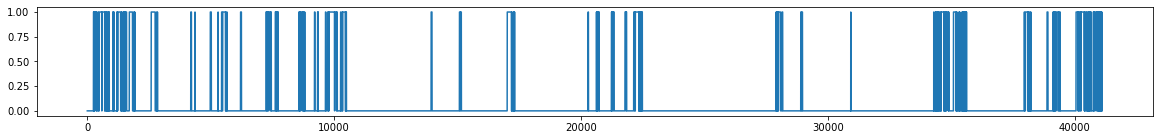

In [197]:
# steeringWheelPressed
plt.figure(figsize=(20,2))
plt.plot(car_state[:,4])

(array([16583923.,  2096847.,  5149924.,  7931629., 12239313., 15513829.,
        17783111., 29127890., 22453174.,  2704360.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

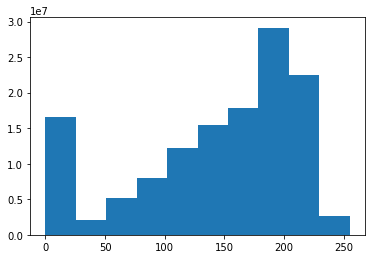

In [198]:
plt.hist(img[::20,:,:,2].flatten())

In [199]:
img.mean()

154.84173296962297

In [200]:
"""for i in range(len(img)):
    img[i] = gamma_correct_auto(img[i])"""

'for i in range(len(img)):\n    img[i] = gamma_correct_auto(img[i])'

<BarContainer object of 10 artists>

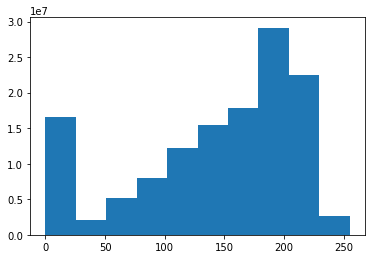

In [201]:
plt.hist(img[::20,:,:,2].flatten())[2]

In [202]:
"""for i in range(len(img)):
    img[i] = img[0] #np.concatenate([img[0].mean(axis=-1, keepdims=True) for _ in range(3)], axis=-1)    
    aux[i, 2] = 80"""

'for i in range(len(img)):\n    img[i] = img[0] #np.concatenate([img[0].mean(axis=-1, keepdims=True) for _ in range(3)], axis=-1)    \n    aux[i, 2] = 80'

In [203]:
aux[:,0] = -.5
aux[:,1] = .5

In [204]:
aux.shape

(41107, 5)

In [205]:
rollout_data = make_vid(run_id, model_stem, img, aux)

(41107, 30) (41107, 1, 13, 80) (41107, 1, 13, 80)
Made vid!


In [206]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

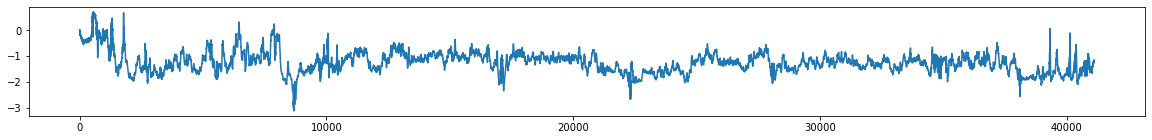

In [207]:
# pitch
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])

In [208]:
obsnet_outs[:,1][:].mean()

-1.238

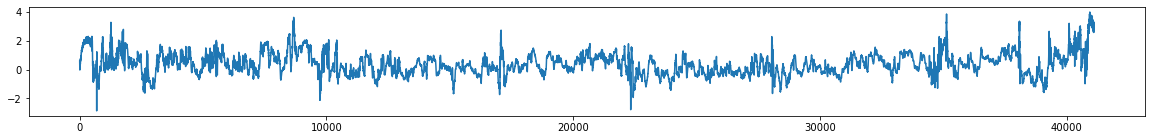

In [209]:
# yaw
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,2])

In [210]:
obsnet_outs[:,2][:].mean()

0.378

In [106]:
%%time
combine_vids(model_stem, "8.18_e34", run_id)

combined!
CPU times: user 17.3 s, sys: 152 ms, total: 17.4 s
Wall time: 17.4 s
